In [10]:
!pip install -q keras-cv keras-hub tensorflow matplotlib numpy

In [11]:
!pip install --upgrade keras-hub

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
from tensorflow import keras
#from keras_cv.models.backbones import ViTBackbone
#from keras_cv.models.classification import ViTClassifier
from keras_hub.models import ViTBackbone, ViTImageClassifier

#load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize images to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print("Training data shape:", x_train.shape)
print("Testing data shape :", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Testing data shape : (10000, 32, 32, 3)


In [13]:
from keras_hub.models import Backbone

#build vision transformer model
#using a light ViT variant for speed
#vit_backbone = Backbone.from_preset("vit_tiny_patch16_224")
vit_backbone = Backbone.from_preset("vit_base_patch16_224_imagenet")

#freeze backbone for fast demo fine-tuning
vit_backbone.trainable = False

#add classification head for CIFAR-10
model = keras.Sequential([
    keras.layers.Resizing(224, 224),
    vit_backbone,
    keras.layers.GlobalAveragePooling1D(), # Add Global Average Pooling layer
    keras.layers.Dense(num_classes, activation="softmax")
])

In [15]:
#compile and train briefly
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=2,       # keep small for demo
                    batch_size=64,
                    verbose=1)

Epoch 1/2


I0000 00:00:1764686117.871629     129 service.cc:148] XLA service 0x7e58540081f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764686117.872464     129 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764686117.872481     129 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764686119.666716     129 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764686123.364378     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 625s 868ms/step - accuracy: 0.7240 - loss: 0.9087 - val_accuracy: 0.9186 - val_loss: 0.2567
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 627s 891ms/step - accuracy: 0.9243 - loss: 0.2462 - val_accuracy: 0.9306 - val_loss: 0.2119


In [18]:
#evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
vit_acc=test_acc
print(f"\n Test accuracy: {vit_acc:.4f}")


 Test accuracy: 0.9286


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


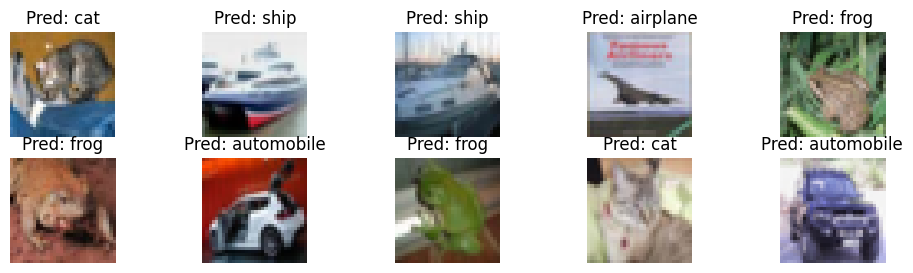

In [19]:
#predict and display results
pred = np.argmax(model.predict(x_test[:10]), axis=1)

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i])
    plt.title(f"Pred: {class_names[pred[i]]}")
    plt.axis('off')
plt.show()

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --------- Device ---------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# --------- Data Transforms ---------
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# --------- Load CIFAR-10 ---------
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# --------- CNN Model ---------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn = SimpleCNN().to(device)

# --------- Loss and Optimizer ---------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# --------- Training Loop ---------
EPOCHS = 10
for epoch in range(EPOCHS):
    cnn.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss/len(train_loader):.4f}")

# --------- Evaluation ---------
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

cnn_acc = correct / total
print(f"CNN Test Accuracy on CIFAR-10: {cnn_acc:.4f}")

Using device: cuda


100%|██████████| 170M/170M [00:05<00:00, 32.4MB/s] 


Epoch [1/10] Loss: 1.5111
Epoch [2/10] Loss: 1.1164
Epoch [3/10] Loss: 0.9408
Epoch [4/10] Loss: 0.8335
Epoch [5/10] Loss: 0.7697
Epoch [6/10] Loss: 0.7224
Epoch [7/10] Loss: 0.6843
Epoch [8/10] Loss: 0.6473
Epoch [9/10] Loss: 0.6269
Epoch [10/10] Loss: 0.6018
CNN Test Accuracy on CIFAR-10: 0.7926


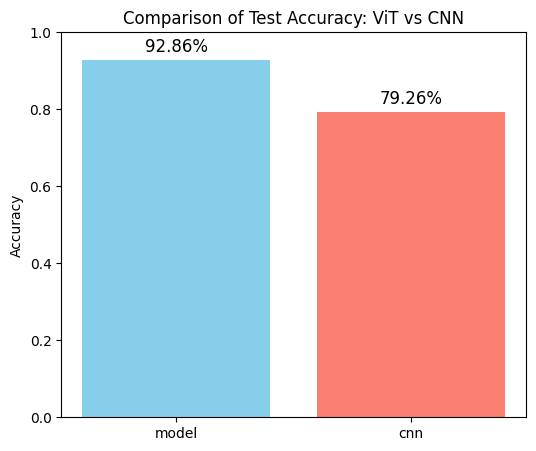

In [20]:
import matplotlib.pyplot as plt

# Accuracy values
models = ['model', 'cnn']
accuracies = [vit_acc, cnn_acc]

# Plot
plt.figure(figsize=(6,5))
plt.bar(models, accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Test Accuracy: ViT vs CNN')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12)
plt.show()